## Final Project Submission

Please fill out:
* Student name: Seyma Tas
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Amber Yandow
* Blog post URL:


In [77]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression, SGDClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import recall_score, f1_score,fbeta_score, r2_score, roc_auc_score, roc_curve, auc, cohen_kappa_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
import xgboost as xgb
# from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('TelcoCustomerChurnData_cleaned_ohe.csv')

# Splitting the data into test and train sets

In [3]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_train = pd.DataFrame(scaled_x_train, columns=X_train.columns)


## Functions to evaluate the model

In [6]:
def roc_curve_and_auc(clf, X_train, X_test, y_train, y_test):

    # Calculate the probability scores of each point in the training set
    y_train_score = clf.fit(X_train, y_train).decision_function(X_train)

    # Calculate the fpr, tpr, and thresholds for the training set
    train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

    # Calculate the probability scores of each point in the test set
    y_test_score = clf.decision_function(X_test)

    # Calculate the fpr, tpr, and thresholds for the test set
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

    # ROC curve for training set
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=lw, label='Train ROC curve')
    plt.plot(test_fpr, test_tpr, color='blue',
             lw=lw, label='Test ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve for Training and Testing Sets')
    plt.legend(loc='lower right')
    plt.show()
    # Print the area under the roc curve
    print('Training AUC: {}'.format(round(auc(train_fpr, train_tpr), 5)))
    print('Testing AUC: {}'.format(round(auc(test_fpr, test_tpr), 5)))

In [7]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [90]:
def model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):

    print('MODEL EVALUATION METRICS:\n',
          '-----------------------------------------------------')
    print('Confusion Matrix for train & test set: \n')
    print(confusion_matrix(y_train, y_pred_train),'\n')
    
    print(confusion_matrix(y_test, y_pred_test))
    
    print('-----------------------------------------------------')
    print('\nClassification Report for train & test set\n',
          '\nTrain set\n',
          classification_report(y_train, y_pred_train),
          '\n\nTest set\n',
          classification_report(y_test, y_pred_test))
    
#     print('\nRecall for train & test set:\n',
#           round(recall_score(y_train, y_pred_train), 4),
#           round(recall_score(y_test, y_pred_test), 4))
       
#     print('Precision for train & test set:\n', 
#           round(precision_score(y_train, y_pred_train), 4),
#           round(precision_score(y_test, y_pred_test), 4))

#     print('f1 score for train & test set:\n', 
#           round(f1_score(y_train, y_pred_train), 4),
#           round(f1_score(y_test, y_pred_test), 4))

#     print('Accuracy for train and test set:\n ',
#           round(accuracy_score(y_train, y_pred_train), 4),
#           round(accuracy_score(y_test, y_pred_test), 4))
    print('-----------------------------------------------------\n')
    print("Cohen's Kappa for train and test set:\n ",
            round(cohen_kappa_score(y_train, y_pred_train), 4),
            round(cohen_kappa_score(y_test, y_pred_test), 4))

    print ("f2 score for train and test set: \n ",
           round(fbeta_score(y_train, y_pred_train, 2.0),4), 
           round(fbeta_score(y_test, y_pred_test, 2.0),4))
    
    print ('roc auc score for train and test set:\n ', 
           round(roc_auc_score(y_train, y_pred_train),4),
           round(roc_auc_score(y_test, y_pred_test),4) )
    
    print('Mean Cross Validation Score:\n', round(cross_val_score(clf, X, y, cv=5).mean(), 4))   

# Logistic Regression

## Baseline model

In [91]:
clf = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [92]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [93]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)


MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[2829 1034]
 [ 275 1136]] 

[[931 369]
 [ 94 364]]
-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      3863
           1       0.52      0.81      0.63      1411

    accuracy                           0.75      5274
   macro avg       0.72      0.77      0.72      5274
weighted avg       0.81      0.75      0.76      5274
 

Test set
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1300
           1       0.50      0.79      0.61       458

    accuracy                           0.74      1758
   macro avg       0.70      0.76      0.71      1758
weighted avg       0.80      0.74      0.75      1758

-------------------------------------------------

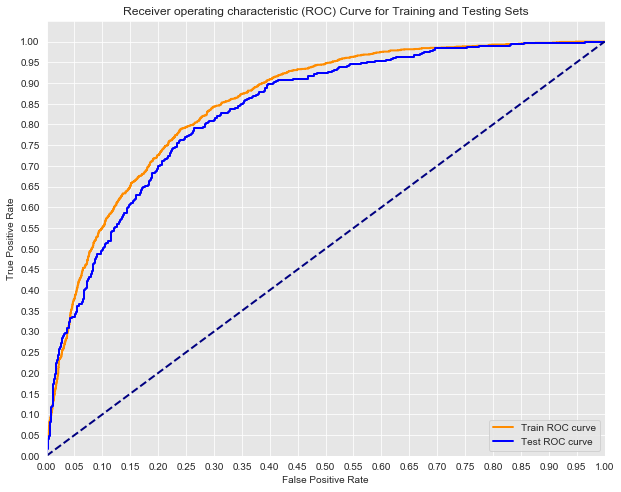

Training AUC: 0.85155
Testing AUC: 0.83391


In [25]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [13]:
clf.coef_.round(2)

array([[-0.06,  0.  ,  0.  , -0.04,  0.24,  0.11, -0.26, -0.54,  0.23,
         0.16,  0.74, -0.1 , -0.1 , -0.48, -0.1 , -0.15, -0.1 , -0.02,
        -0.1 , -0.44, -0.1 ,  0.15, -0.1 ,  0.2 , -0.69, -1.03,  0.22,
        -0.16,  0.21, -0.08]])

In [ ]:
# plot_feature_importances(clf)

### Note: I tried all the other solvers here, 'liblinear' gave the best results.

## Handling Imbalanced Data

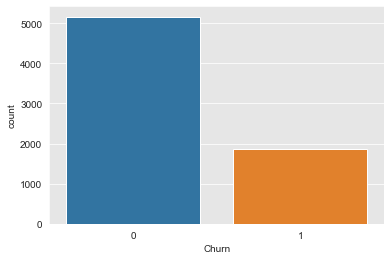

In [14]:
sns.countplot(y);

In [15]:
print(y.value_counts())
print(y.value_counts(normalize=True))

0    5163
1    1869
Name: Churn, dtype: int64
0    0.734215
1    0.265785
Name: Churn, dtype: float64


## SMOTE


In [16]:
smote = SMOTE()
scaled_X_train_smoted, y_train_smoted = smote.fit_sample(scaled_X_train, y_train)

## ADASYN

In [94]:
adasyn = ADASYN()
X_train_ada, y_train_ada = adasyn.fit_sample(X_train, y_train)

In [95]:
clf = LogisticRegression(fit_intercept=False, C=1e20, solver ='liblinear')
clf.fit(X_train_ada, y_train_ada)
y_pred_train = clf.predict(X_train_ada)
y_pred_test = clf.predict(X_test)

In [96]:
model_evaluation(X_train_ada, X_test, y_train_ada, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[2725 1138]
 [ 758 3147]] 

[[899 401]
 [ 80 378]]
-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.78      0.71      0.74      3863
           1       0.73      0.81      0.77      3905

    accuracy                           0.76      7768
   macro avg       0.76      0.76      0.76      7768
weighted avg       0.76      0.76      0.76      7768
 

Test set
               precision    recall  f1-score   support

           0       0.92      0.69      0.79      1300
           1       0.49      0.83      0.61       458

    accuracy                           0.73      1758
   macro avg       0.70      0.76      0.70      1758
weighted avg       0.81      0.73      0.74      1758

-------------------------------------------------

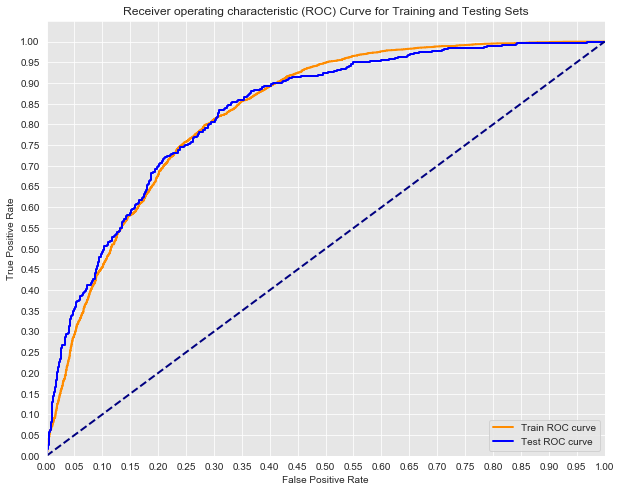

Training AUC: 0.8307
Testing AUC: 0.83161


In [30]:
roc_curve_and_auc(clf, X_train_ada, X_test, y_train_ada, y_test)

In [33]:
clf.coef_.round(2)

array([[-0.06,  0.02,  0.  ,  0.02,  0.28,  0.12, -0.29, -0.22,  0.74,
         0.1 ,  0.08, -0.03, -0.03, -0.56, -0.03, -0.27, -0.03, -0.14,
        -0.03, -0.5 , -0.03, -0.02, -0.03,  0.07, -0.87, -1.5 ,  0.28,
        -0.07,  0.45, -0.09]])

In [35]:
# plot_feature_importances(clf)

# L1 regression (Lasso)

In [97]:
clf = SGDClassifier(penalty='elasticnet')
clf.fit(scaled_X_train_smoted, y_train_smoted)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [98]:
y_pred_train = clf.predict(scaled_X_train_smoted)
y_pred_test = clf.predict(scaled_X_test)

In [99]:
model_evaluation(scaled_X_train_smoted, scaled_X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[2774 1089]
 [ 667 3196]] 

[[921 379]
 [ 97 361]]
-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.81      0.72      0.76      3863
           1       0.75      0.83      0.78      3863

    accuracy                           0.77      7726
   macro avg       0.78      0.77      0.77      7726
weighted avg       0.78      0.77      0.77      7726
 

Test set
               precision    recall  f1-score   support

           0       0.90      0.71      0.79      1300
           1       0.49      0.79      0.60       458

    accuracy                           0.73      1758
   macro avg       0.70      0.75      0.70      1758
weighted avg       0.80      0.73      0.74      1758

-------------------------------------------------

In [100]:
clf = SGDClassifier(penalty='elasticnet',class_weight='balanced')
clf.fit(scaled_X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [101]:
y_pred_train = clf.predict(scaled_X_train)
y_pred_test = clf.predict(scaled_X_test)

In [102]:
model_evaluation(scaled_X_train, scaled_X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[2583 1280]
 [ 236 1175]] 

[[846 454]
 [ 83 375]]
-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.92      0.67      0.77      3863
           1       0.48      0.83      0.61      1411

    accuracy                           0.71      5274
   macro avg       0.70      0.75      0.69      5274
weighted avg       0.80      0.71      0.73      5274
 

Test set
               precision    recall  f1-score   support

           0       0.91      0.65      0.76      1300
           1       0.45      0.82      0.58       458

    accuracy                           0.69      1758
   macro avg       0.68      0.73      0.67      1758
weighted avg       0.79      0.69      0.71      1758

-------------------------------------------------

# KNN

In [105]:
k_range = range(1, 26)

for k in k_range:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(scaled_X_train_smoted, y_train_smoted)
    y_pred_train = clf.predict(scaled_X_train_smoted)
    y_pred_test = clf.predict(scaled_X_test)
    
    print('------------')
    print(k)
    print('\nClassification Report for train & test set\n',
              '\nTrain set\n',
              classification_report(y_train_smoted, y_pred_train),
              '\n\nTest set\n',
              classification_report(y_test, y_pred_test))
    print('-----------------------------------------------\n')
    
    print ("f2 score for train and test set: \n ",
           round(fbeta_score(y_train_smoted, y_pred_train, 2.0),4), 
           round(fbeta_score(y_test, y_pred_test, 2.0),4))
    

------------
1

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3863
           1       1.00      1.00      1.00      3863

    accuracy                           1.00      7726
   macro avg       1.00      1.00      1.00      7726
weighted avg       1.00      1.00      1.00      7726
 

Test set
               precision    recall  f1-score   support

           0       0.82      0.76      0.79      1300
           1       0.43      0.52      0.47       458

    accuracy                           0.70      1758
   macro avg       0.62      0.64      0.63      1758
weighted avg       0.72      0.70      0.70      1758

-----------------------------------------------

f2 score for train and test set: 
  0.9985 0.4954
------------
2

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.93      1.00   

------------
11

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.91      0.70      0.79      3863
           1       0.76      0.93      0.84      3863

    accuracy                           0.82      7726
   macro avg       0.84      0.82      0.81      7726
weighted avg       0.84      0.82      0.81      7726
 

Test set
               precision    recall  f1-score   support

           0       0.90      0.65      0.76      1300
           1       0.45      0.81      0.58       458

    accuracy                           0.69      1758
   macro avg       0.68      0.73      0.67      1758
weighted avg       0.79      0.69      0.71      1758

-----------------------------------------------

f2 score for train and test set: 
  0.8916 0.6944
------------
12

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.90      0.73 

------------
21

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.89      0.66      0.76      3863
           1       0.73      0.92      0.82      3863

    accuracy                           0.79      7726
   macro avg       0.81      0.79      0.79      7726
weighted avg       0.81      0.79      0.79      7726
 

Test set
               precision    recall  f1-score   support

           0       0.92      0.62      0.74      1300
           1       0.44      0.84      0.58       458

    accuracy                           0.68      1758
   macro avg       0.68      0.73      0.66      1758
weighted avg       0.79      0.68      0.70      1758

-----------------------------------------------

f2 score for train and test set: 
  0.8758 0.7077
------------
22

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.88      0.68 

### I chose n = 14 because it has a high recall value,  less overfitting. KNN is not the best algorithm in this data but I tried to make it as effiective as I can. High variance
I tried ADASYN here but it did not give better results than SMOTE.

In [109]:
clf = KNeighborsClassifier(n_neighbors=14)
clf.fit(scaled_X_train_smoted, y_train_smoted)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                     weights='uniform')

In [110]:
y_pred_train = clf.predict(scaled_X_train_smoted)
y_pred_test = clf.predict(scaled_X_test)

In [111]:
model_evaluation(scaled_X_train_smoted, scaled_X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[2766 1097]
 [ 344 3519]] 

[[875 425]
 [ 95 363]]
-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.89      0.72      0.79      3863
           1       0.76      0.91      0.83      3863

    accuracy                           0.81      7726
   macro avg       0.83      0.81      0.81      7726
weighted avg       0.83      0.81      0.81      7726
 

Test set
               precision    recall  f1-score   support

           0       0.90      0.67      0.77      1300
           1       0.46      0.79      0.58       458

    accuracy                           0.70      1758
   macro avg       0.68      0.73      0.68      1758
weighted avg       0.79      0.70      0.72      1758

-------------------------------------------------

# SVM classifier

In [123]:
sample_X_train = X_train.sample(n=1000)
sample_y_train = y_train.sample(n=1000)

In [ ]:
clf = SVC(kernel='linear', class_weight='balanced')
clf.fit(sample_X_train, sample_y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

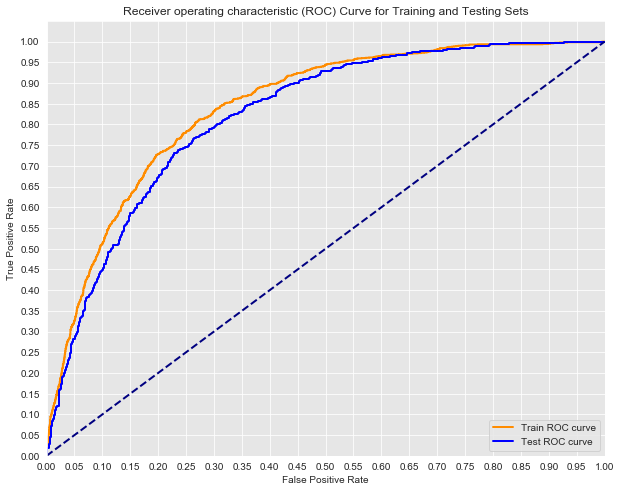

Training AUC: 0.8415
Testing AUC: 0.82093


In [76]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

# SVM classifier smote gridsearch

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
clf = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  

clf.fit(scaled_X_train_smoted, y_train_smoted) 

In [ ]:
y_pred_train = clf.predict(scaled_X_train_smoted)
y_pred_test = clf.predict(scaled_X_test)

In [ ]:
model_evaluation(scaled_X_train_smoted, scaled_X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)

In [ ]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

# Naive Bayes

In [ ]:
clf = GaussianNB()
clf.fit(scaled_X_train_smoted, y_train_smoted)
y_pred_train = clf.predict(scaled_X_train_smoted)
y_pred_test = clf.predict(scaled_X_test)

In [ ]:
model_evaluation(scaled_X_train_smoted, scaled_X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)

In [ ]:
# roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [ ]:
# clf.feature_importances_

In [ ]:
# plot_feature_importances(clf)

Feature Importance
Class Weight
Over Under SAmpling SMOTE yaptim
Stratify
Radius Neighbors Classifier Cok fazla model oldu
bagging yaptim
make_scorer

simple imputer
n_jobs = -1

cohen_kappa_score
Cohen suggested the Kappa result be interpreted as follows: values ≤ 0 as indicating no agreement and 0.01–0.20 as none to slight, 0.21–0.40 as fair, 0.41– 0.60 as moderate, 0.61–0.80 as substantial, and 0.81–1.00 as almost perfect agreement.

In [ ]:
William’s SVM kernel=‘poly’ Gamma = ‘0.1’ c=1 

In [ ]:
# Plot features importances metric evaluation fonksiyonuna bunu ekleyecegim
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')